In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Descenso del gradiente

En primer lugar vamos a ver el algoritmo de descenso de gradiente "básico".

Supongamos la función $$f(x)=x^2 - 2x + 4$$ de la que queremos encontrar su mínimo.

In [2]:
f = lambda x: x**2 - 2*x + 4 

En primer lugar calculamos su derivada:

In [4]:
f_prima = lambda x: 2*x - 2

Definimos el tamaño de paso (también llamado ratio de aprendizaje) para modificar el mínimo en cada iteración.

In [5]:
STEP_SIZE = 0.02

Definimos el algoritmo del descenso de gradiente.

$$\theta_{i} = \theta_{i-1} - \alpha*\nabla(J(\theta_{i-1}))$$


In [6]:
def descenso_gradiente(x):
    return x - STEP_SIZE*(f_prima(x))

Ahora para un mínimo local elegido al azar podemos *"mejorarlo"* aplicando el descenso de gradiente

In [7]:
x0 = 3

descenso_gradiente(x0)

2.92

Ahora podemos aplicar el algoritmo de forma iterativa

In [8]:
minimo_iteraciones = []
N_ITERACIONES = 100

x = 3
for i in range(N_ITERACIONES):
    minimo_iteraciones.append(x)
    x = descenso_gradiente(x)

In [9]:
plt.rcParams["figure.figsize"] = (6, 6)

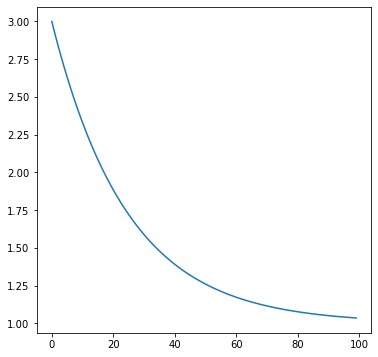

In [10]:
plt.plot(minimo_iteraciones);

Vemos que converge al mínimo de la función.

# Batch Gradient Descent

Cargamos los datos, en esta ocasión vamos a usar una función de `sklearn` llamada [make_regresion](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression) que genera un dataset sintético creado mediante una regresión lineal.

In [11]:
from sklearn.datasets import make_regression

In [12]:
n_muestras = 1000
n_variables = 2

In [13]:
X, y, coeficientes_objetivo = make_regression(n_samples=n_muestras,
                                              n_features=n_variables,
                                              coef=True)

Lo bueno de usar este dataset es que sabemos exactamente cuales son los coeficientes $\beta_i$ que definen el modelo lineal que genera la variable objetivo

In [14]:
coeficientes_objetivo

array([83.79385327, 64.37563718])

Podemos obtener la variable objetivo mediante un producto escalar de los pesos con las variables independientes

In [15]:
def predecir_batch(coeficientes, X):
    return coeficientes @ X.T

In [16]:
y_predicciones = predecir_batch(coeficientes_objetivo, X)
y_predicciones[:10]

array([160.51019875, 126.91331217,  61.44048889,   8.62621776,
       -24.9400506 ,   5.55231815, -79.74879837,  52.99556726,
       -30.50217748,   7.39032779])

Comprobamos que dichas predicciones son exactamente iguales que la variable objetivo

In [17]:
y_predicciones[:10]-y[:10]

array([ 0.00000000e+00,  0.00000000e+00, -7.10542736e-15, -7.10542736e-15,
        0.00000000e+00,  0.00000000e+00,  1.42108547e-14,  7.10542736e-15,
        0.00000000e+00, -6.21724894e-15])

Necesitamos una función de error, en este caso usaremos el **Error Cuadrático Medio** dividido entre 2, para que su derivada no tenga el 2

In [18]:
def error_batch(y_pred, y_true):
    m = y_pred.shape[0]
    return (np.sum(y_pred - y_true)**2)/2*m

También necesitamos la derivada de la función de error.

In [19]:
def derivada_error_batch(y_pred, y_true, x):
    m = y_pred.shape[0]
    return np.sum((y_pred - y_true)*x/m)

Para empezar el proceso generamos los coeficientes iniciales al azar

In [20]:
coeficientes = np.random.random((X.shape[1],))
coeficientes

array([0.56613324, 0.51725797])

In [21]:
coeficientes_objetivo

array([83.79385327, 64.37563718])

Ahora podemos predecir y calcular el error y la derivada del error

In [22]:
y_pred = predecir_batch(coeficientes, X)

In [23]:
error_batch(y_pred, y)

9994276487.343084

In [24]:
derivada_error_batch(y_pred, y, X[:,0])

-88.77172687319343

ya tenemos todo para implementar el descenso de gradiente batch

In [25]:
def descenso_gradiente_batch(coeficientes, X, y):
    y_predicciones = predecir_batch(coeficientes, X)
    for i in range(coeficientes.shape[0]):
        coeficientes[i] = coeficientes[i]- STEP_SIZE * derivada_error_batch(y_predicciones, y, X[:,i])
    error = error_batch(y_predicciones, y)
    return coeficientes, error


Simplemente definimos un número de iteraciones y un tamaño de paso (tambien llamado **ratio de aprendizaje o learning rate**), iteraremos y en cada iteración modificaremos los parámetros del modelo en función del tamaño de paso.

In [26]:
coeficientes_iteraciones = []
error_iteraciones = []

N_ITERACIONES = 200
STEP_SIZE = 0.02
coeficientes = np.random.random((X.shape[1],))
error = error_batch(coeficientes, X)
for i in range(N_ITERACIONES):
    coeficientes_iteraciones.append(coeficientes.copy())
    error_iteraciones.append(error)
    coeficientes, error = descenso_gradiente_batch(coeficientes, X, y)

coeficientes_iteraciones = np.array(coeficientes_iteraciones)

In [27]:
coeficientes

array([82.63803783, 62.83863066])

Vemos que los coeficientes obtenidos se parecen mucho a los coeficientes objetivo.

In [28]:
coeficientes_objetivo

array([83.79385327, 64.37563718])

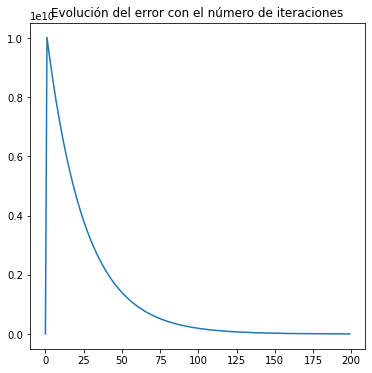

In [29]:
plt.plot(error_iteraciones)
plt.title("Evolución del error con el número de iteraciones");

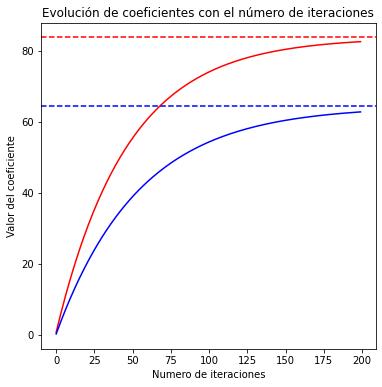

In [30]:
plt.plot(coeficientes_iteraciones[:,0], color="red")
plt.axhline(coeficientes_objetivo[0], color="red", linestyle="dashed")

plt.plot(coeficientes_iteraciones[:,1], color="blue")
plt.axhline(coeficientes_objetivo[1], color="blue", linestyle="dashed")

plt.xlabel("Numero de iteraciones")
plt.ylabel("Valor del coeficiente")

plt.title("Evolución de coeficientes con el número de iteraciones");

# Descenso de gradiente estocástico (SGD)

In [31]:
def predecir_observacion(coeficientes, x):
    return coeficientes @ x.T

In [32]:
X[0]

array([1.68964464, 0.29402993])

In [33]:
predecir_observacion(coeficientes, X[0])

158.1053554692938

In [34]:
def derivada_error_observacion(y_pred, y_true, x):
    return (y_pred - y_true) * x

In [35]:
derivada_error_observacion(
    predecir_observacion(coeficientes, X[0]), y[0], X[0])

array([-4.06333056, -0.70709589])

la definición de la iteracion de sgd es similar a la de batch, simplemente usando el error de observación en vez de el error total

In [36]:
def descenso_gradiente_estocastico(coeficientes, x, y):
    y_predicciones = predecir_observacion(coeficientes, x)
    for i in range(coeficientes.shape[0]):
        coeficientes[i] = coeficientes[i]- STEP_SIZE * derivada_error_observacion(y_predicciones, y, x[i])
    return coeficientes

Ahora hacemos solo una iteración (podriamos hacer más), pero la iteramos para cada observación individual.

In [37]:
coeficientes_iteraciones = []
error_iteraciones = []

STEP_SIZE = 0.02
coeficientes = np.random.random((X.shape[1],))
error = error_batch(coeficientes, X)

indice_aleatorio = np.random.permutation(X.shape[0])
for i in indice_aleatorio:
    error_iteraciones.append(error)
    coeficientes_iteraciones.append(coeficientes.copy())
    
    x_iteracion = X[i]
    y_iteracion = y[i]
    coeficientes = descenso_gradiente_estocastico(coeficientes,
                                                  x_iteracion,
                                                  y_iteracion)
    y_predicciones = predecir_batch(coeficientes, X)
    error = error_batch(y_predicciones, y)
    
coeficientes_iteraciones = np.array(coeficientes_iteraciones)

In [38]:
coeficientes

array([83.79385315, 64.37563703])

In [39]:
coeficientes_objetivo

array([83.79385327, 64.37563718])

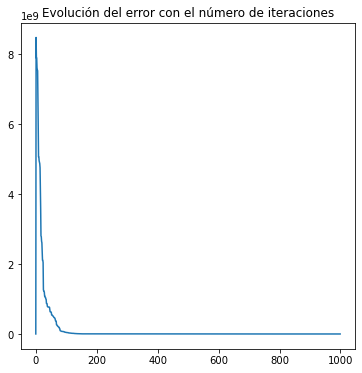

In [40]:
plt.plot(error_iteraciones)
plt.title("Evolución del error con el número de iteraciones");

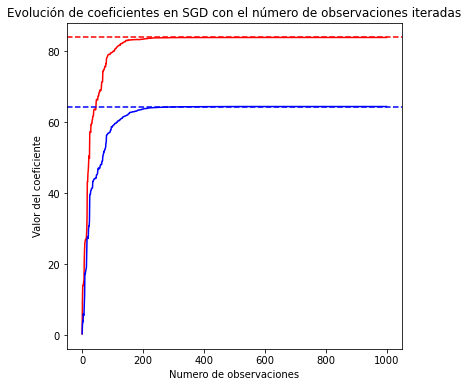

In [41]:
plt.plot(coeficientes_iteraciones[:,0], color="red")
plt.axhline(coeficientes_objetivo[0], color="red", linestyle="dashed")

plt.plot(coeficientes_iteraciones[:,1], color="blue")
plt.axhline(coeficientes_objetivo[1], color="blue", linestyle="dashed")

plt.xlabel("Numero de observaciones")
plt.ylabel("Valor del coeficiente")

plt.title("Evolución de coeficientes en SGD con el número de observaciones iteradas");

### SGD en scikit-learn

Scikit-learn tiene estimadores para regresión y clasificación basados en SGD, [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor) y [SGDClassifier](from sklearn.linear_model import SGDClassifier)

Los parámetros más importantes para estos estimadores son:

- **loss**: La función de pérdidas a utilizar
- **learning_rate**: El tamaño de paso, también llamado learning rate (ratio de aprendizaje)
- **max_iter**: Número de iteraciones (también llamadas épocas)

In [42]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

In [43]:
estimador_sgd = SGDRegressor(max_iter=10)
estimador_sgd.fit(X, y)

C:\Users\mario\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDRegressor(max_iter=10)

In [44]:
estimador_sgd.predict(X)[:10]

array([160.49492707, 126.89912616,  61.43359482,   8.62690875,
       -24.93666239,   5.55203268, -79.74090194,  52.99141091,
       -30.49850334,   7.39117016])

Podemos ver los coeficientes que produce el estimador

In [45]:
estimador_sgd.coef_

array([83.78577353, 64.36833417])

Y vemos que son muy similares a los coeficientes objetivo

In [46]:
coeficientes_objetivo

array([83.79385327, 64.37563718])

Y por supuesto, podemos hacer validación cruzada como con cualquier estimador de `sklearn`

In [47]:
from sklearn.model_selection import cross_val_score

cross_val_score(SGDRegressor(max_iter=10), X, y, 
                scoring="neg_mean_squared_error")

C:\Users\mario\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\mario\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\mario\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\mario\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before 

array([-0.00017   , -0.00020524, -0.00012577, -0.00016676, -0.00012776])